In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #to normalize data
from os.path import exists

In [2]:
#see https://github.com/archd3sai/Predictive-Maintenance-of-Aircraft-Engine/blob/master/RUL%20Prediction%20Regression/LSTM%20RUL%20Prediction.ipynb
#dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    
df_train = pd.read_csv('train_FD004.txt',delim_whitespace=True,names=input_file_column_names)

df_train = df_train.drop(cols_to_drop, axis = 1)

In [3]:
print("Predictive Maintenance techniques are used to determine the condition of an equipment to plan the maintenance/failure ahead of its time\n")
print("Classification: Predicting the failure of machine in upcoming n days\n")
print("The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cycles\n")
print("RUL - remaining useful life\n\n")
print(df_train.head(1))

Predictive Maintenance techniques are used to determine the condition of an equipment to plan the maintenance/failure ahead of its time

Classification: Predicting the failure of machine in upcoming n days

The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cycles

RUL - remaining useful life


   UnitNumber  Cycle   OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1  42.0049    0.84          549.68         1343.43   

   SensorMeasure4  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0         1112.93          137.36         2211.86         8311.32   

   SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure15  \
0            41.69           129.78          2387.99           9.3335   

   SensorMeasure17  SensorMeasure20  SensorMeasure21  
0              330            10.62            6.367  


In [4]:
print("Find the max cycle count for each unit\n"
     )
rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
print(rul.head(3))

df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
df_train['RUL'] = df_train['max'] - df_train['Cycle']
df_train.drop('max', axis=1, inplace=True)
print(df_train.head(3))

Find the max cycle count for each unit

   UnitNumber  max
0           1  321
1           2  299
2           3  307
   UnitNumber  Cycle   OpSet1  OpSet2  SensorMeasure2  SensorMeasure3  \
0           1      1  42.0049  0.8400          549.68         1343.43   
1           1      2  20.0020  0.7002          606.07         1477.61   
2           1      3  42.0038  0.8409          548.95         1343.12   

   SensorMeasure4  SensorMeasure7  SensorMeasure8  SensorMeasure9  \
0         1112.93          137.36         2211.86         8311.32   
1         1237.50          332.10         2323.66         8713.60   
2         1117.05          138.18         2211.92         8306.69   

   SensorMeasure11  SensorMeasure12  SensorMeasure13  SensorMeasure15  \
0            41.69           129.78          2387.99           9.3335   
1            43.94           312.59          2387.73           9.1913   
2            41.66           129.62          2387.97           9.4007   

   SensorMeasure17  S

In [5]:
#y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
#y_true["UnitNumber"] = y_true.index

#print(y_true)

In [6]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

X_Columns = [column for column in df_train.columns if column !="RUL"]

min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[X_Columns] = min_max_scaler.fit_transform(df_train[X_Columns])

sequence_length=50

X_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, X_Columns)) for unit in df_train['UnitNumber'].unique()))
print("X_train",X_train.shape)
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) for unit in df_train['UnitNumber'].unique()))
print("y_train",y_train.shape)

X_train (49048, 50, 17)
y_train (49048,)


In [11]:
nb_features = X_train.shape[2]
nb_out = 1



model = Sequential()
model.add(Bidirectional(LSTM(
         units=512,
         return_sequences=True,
         input_shape=(sequence_length, nb_features))))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(
          units=128,
          return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
model.build(X_train.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (49048, 50, 1024)        2170880   
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (49048, 50, 1024)        4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (49048, 50, 1024)         0         
                                                                 
 bidirectional_5 (Bidirectio  (49048, 256)             1180672   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (49048, 256)              0         
                                                      

In [12]:

print ("Train the model")
length=len(X_train)
path_to_file="D:\\RulNasa\\lstm_aircraft_model4birmse.h5"

file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
    
history=model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

model.save_weights(path_to_file)


Train the model
Epoch 1/3
1380/1380 [==============================] - 1218s 878ms/step - loss: 6233.3003 - mape: 332753824.0000 - val_loss: 4429.6729 - val_mape: 529062976.0000
Epoch 2/3
1380/1380 [==============================] - 952s 690ms/step - loss: 3239.2900 - mape: 138177264.0000 - val_loss: 5962.9883 - val_mape: 69682856.0000
Epoch 3/3
1380/1380 [==============================] - 957s 694ms/step - loss: 2870.3164 - mape: 84348504.0000 - val_loss: 13730.5234 - val_mape: 628252736.0000


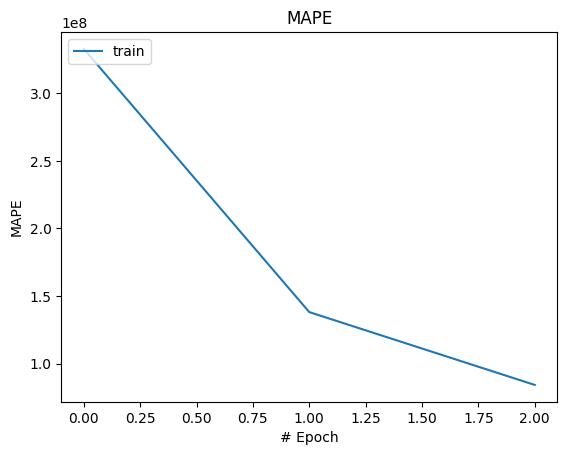

In [14]:
plt.plot(history.history['mape'])
#plt.plot(history.history['val_mean_squared_error'])
plt.title('MAPE')
plt.ylabel('MAPE')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [15]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('RMSE: {}'.format(scores[1]))

246/246 [==============================] - 194s 789ms/step - loss: 12519.8564 - mape: 570719872.0000
RMSE: 570719872.0


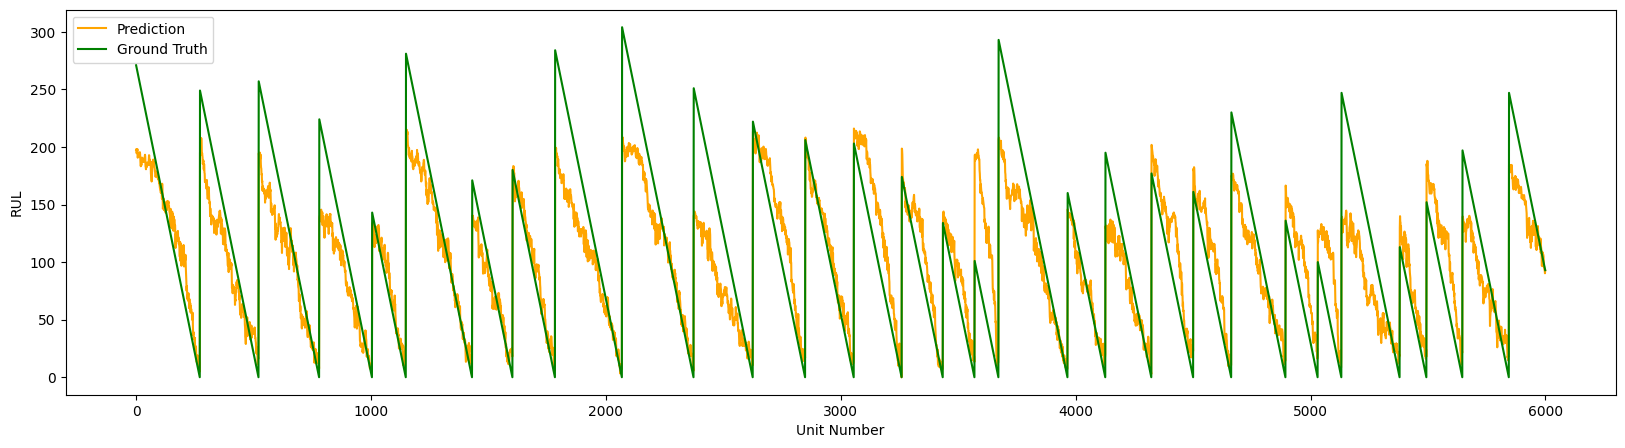

In [26]:
y_pred_test = model.predict(X_train[0:6000], verbose=0)

plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color='orange', label='Prediction')
plt.plot(y_train[0:6000], color='green', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

In [20]:
print("done!")

done!
